# Testing XGB on Psuedo Gamma datasets 

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from coremdlr.datasets import WellLoader, FaciesDataset
from coremdlr.models import FeaturePredictor, LambdaModel

Using TensorFlow backend.


### Compare scaling methods

In [2]:
fdset = FaciesDataset(["205-21b-3", "204-24a-6", "204-20-6a", "204-20-1Z"],
                    test_wells=["204-19-6"],
                    features=["pseudoGR", "logs"],
                    pseudoGR_args={'scale_mode': 'robust'}, # can change
                    label_resolution=32)

fdset.load_or_generate_data()

Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data


/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:72: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:76: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS
Feature shapes:  [('depth', (3842,)), ('top', (3842,)), ('base', (3842,)), ('pseudoGR', (3842, 32, 8)), ('logs', (3842, 11))]
Loading Well:  204-24a-6  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2
Feature shapes:  [('depth', (13006,)), ('top', (13006,)), ('base', (13006,)), ('pseudoGR', (13006, 32, 8)), ('logs', (13006, 11))]
Loading Well:  204-20-6a  from  /home/administrator/Dropbox/core_data/facies/train_data
Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


Header section Parameter regexp=~P was not found.


Adding NaN log:  SP
Adding NaN log:  DTS1
Adding NaN log:  DTS2


ValueError: b'os' is not in list

In [3]:
for scale_mode in [None, 'minmax', 'standard', 'robust', 'power']:
    
    fdset = FaciesDataset(["205-21b-3", "204-20-6a", "204-19-6", "204-24a-6"],
                    test_wells=[],
                    features=["pseudoGR"],
                    pseudoGR_args={'scale_mode': scale_mode},
                    label_resolution=32)
    
    fdset.load_or_generate_data()
    
    pGR = fdset.X_train['pseudoGR'].flatten()
    min_y, max_y = pGR.min(), pGR.max()
    
    plt.figure(figsize=(20,5))
    plt.title(scale_mode, size=24)
    plt.plot(np.arange(pGR.size), pGR)
    
    for idx in fdset.X_train['boundary_idxs']:
        plt.plot([idx*32, idx*32], [min_y,max_y], color='red')
        
    plt.show()

Loading well with dummy labels. DO NOT TRAIN ON THIS WELL!
Loading well with dummy labels. DO NOT TRAIN ON THIS WELL!
Loading well with dummy labels. DO NOT TRAIN ON THIS WELL!
Loading well with dummy labels. DO NOT TRAIN ON THIS WELL!
Loading Well:  205-21b-3  from  /home/administrator/Dropbox/core_data/facies/train_data
Loading well with dummy labels. DO NOT TRAIN ON THIS WELL!


/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:72: RuntimeWarning: Mean of empty slice
  output_features.append(np.nanmean(img, axis=1))
/home/administrator/code/python/coremdlr/coremdlr/facies/datasets/utils.py:76: RuntimeWarning: Degrees of freedom <= 0 for slice.
  output_features.append(np.nanvar(img, axis=1))


Extracted pGR features:  ['Umean', 'Rmean', 'Gmean', 'Bmean', 'Uvar', 'Rvar', 'Gvar', 'Bvar']


ValueError: setting an array element with a sequence.

In [4]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
import hyperopt
from hyperopt import hp
from hyperopt.pyll.base import scope
from sklearn.metrics import f1_score, log_loss
from sklearn.utils.class_weight import compute_sample_weight

from scipy.stats import mstats


# for balanced log_loss computation
sample_weights = compute_sample_weight('balanced', fdset.y_test) 

# feat_names = ['mean', 'median', 'hmean', 'gmean', 'var', 'IF_0', 'IF_1', 'Chi2', 'p-val']
feat_names = ['mean', 'median', 'gmean', 'var', 'IF_0', 'IF_1', 'm3', 'm2', 'm1', 'b']

def polyfit_coeffs(x):
    p = np.ma.polyfit(np.arange(x.shape[1]), x.T, 3)
    return p.T


def reduce_function(x):
    feats = []
    x = np.ma.masked_invalid(x)
    feats.append(np.mean(x, axis=-1))
    feats.append(np.median(x, axis=-1))
    #feats.append(mstats.hmean(x-x.min(), axis=-1))
    feats.append(mstats.gmean(x, axis=-1))
    feats.append(np.var(x, axis=-1))
    
    # feats.append(sp.signal.qspline1d(x))
    ideal_fourths = mstats.idealfourths(x, axis=-1)
    feats.append(ideal_fourths[:, 0])
    feats.append(ideal_fourths[:, 1])
    
    coeffs = polyfit_coeffs(x)
    for i in range(4):
        feats.append(coeffs[:,i])
    
    #normal_test = mstats.normaltest(x, axis=1)
    #feats.append(normal_test[0])
    #feats.append(normal_test[1])
    # kur_test = mstats.kurtosistest(x, axis =-1)
    # feats.append(kurtosistest[:, 0])
    # feats.append(kurtosistest[:, 1])
    
    x_feats = np.array(feats).T
    return x_feats


feat_model_args = {
    # NOTE: key needs to be feature name AND feature must be specified in model_args
    'pseudoGR': {
        'model' : 'LambdaModel',
        'model_args' : {
            'feature' : 'pseudoGR',
            'lambda_fn' : reduce_function
        }
    }
}

XGB_SEARCH_SPACE = {
    'model_type' : 'XGB',
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 1000, 1)),
    'objective' : 'multi:softprob',
    'n_jobs' : 2,
    'gamma' : hp.uniform('gamma', 0, 0.5),
    'subsample' : hp.uniform('subsample', 0.3, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1.0),
    'colsample_bylevel' : 1,
    'reg_alpha' : 0,                                    # L1 penalty
    'reg_lambda' : hp.uniform('reg_lambda', 0.1, 10),   # L2 penalty
    'tree_method' : 'gpu_exact',
}

def train_xgb_model(model_config):
    xgb_predictor = FeaturePredictor(fdset, 
                                     model_args=model_config, 
                                     feature_model_args=feat_model_args)
    test_acc = xgb_predictor.fit(fdset, verbose=False)
    y_pred = xgb_predictor.predict(fdset.X_test)
    print('F1 score:', f1_score(fdset.y_test, y_pred, average='macro'))
    return log_loss(fdset.y_test, xgb_predictor.predict_proba(fdset.X_test)) #, sample_weight=sample_weights)

AttributeError: 'FaciesDataset' object has no attribute 'y_test'

In [6]:
best_params = hyperopt.fmin(
    fn=train_xgb_model,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=20
)

NameError: name 'train_xgb_model' is not defined

In [7]:
best_params

NameError: name 'best_params' is not defined

In [18]:
params = {**XGB_SEARCH_SPACE, 
          **best_params, 
          **{'max_depth': int(best_params['max_depth']), 'n_estimators': int(best_params['n_estimators'])}}

xgb_predictor = FeaturePredictor(fdset, model_args=params, feature_model_args=feat_model_args)
xgb_predictor.fit(fdset, verbose=True)

imps = list(zip(feat_names, xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
[print(pair) for pair in imps[::-1]]

Training model for feature:  pseudoGR
                      precision    recall  f1-score   support

           sandstone       0.67      0.83      0.74       934
clay-prone sandstone       0.06      0.01      0.01       307
      sandy mudstone       0.31      0.34      0.32       285
            mudstone       0.52      0.56      0.54       358

           micro avg       0.57      0.57      0.57      1884
           macro avg       0.39      0.43      0.41      1884
        weighted avg       0.49      0.57      0.52      1884

Total accuracy Score :  0.5705944798301487
Confusion Matrix: 
 [[774   1  81  78]
 [240   2  41  24]
 [ 97   9  97  82]
 [ 40  21  95 202]]
('var', 0.23755158)
('IF_0', 0.122206144)
('IF_1', 0.12049097)
('b', 0.106983975)
('m1', 0.090368226)
('m3', 0.07696843)
('median', 0.07503886)
('m2', 0.0655518)
('mean', 0.057297528)
('gmean', 0.04754248)


[None, None, None, None, None, None, None, None, None, None]

In [24]:
import pandas as pd

df = pd.DataFrame(columns=['proba_0', 'proba_1', 'proba_2', 'proba_3'])

df['y_pred'] = xgb_predictor.predict(fdset.X_test)
df['y_true'] = fdset.y_test

probas = xgb_predictor.predict_proba(fdset.X_test)

df['confidence'] = np.max(probas, axis=1)
df['regression'] = np.matmul(probas, np.arange(4))
df[['proba_0', 'proba_1', 'proba_2', 'proba_3']] = probas

df

,proba_0,proba_1,proba_2,proba_3,y_pred,y_true,confidence,regression
0,0.605535,0.077053,0.045951,0.271461,0,3,0.605535,0.983338
1,0.380717,0.150265,0.144761,0.324257,0,3,0.380717,1.412557
2,0.477954,0.131226,0.251586,0.139233,0,3,0.477954,1.052099
3,0.336278,0.146381,0.361847,0.155493,2,3,0.361847,1.336556
4,0.499443,0.119775,0.272626,0.108157,0,3,0.499443,0.989497
5,0.388417,0.180838,0.285031,0.145714,0,3,0.388417,1.188042
6,0.347153,0.172329,0.316651,0.163866,0,3,0.347153,1.297231
7,0.350827,0.148594,0.362738,0.137841,2,3,0.362738,1.287593
8,0.319974,0.176045,0.357020,0.146962,2,3,0.357020,1.330969
9,0.432444,0.166799,0.230379,0.170378,0,0,0.432444,1.138692


## Try Power Scaling

In [3]:
del fdset

fdset2 = FaciesDataset(["205-21b-3", "204-24a-6", "204-20-6a"],
                    test_wells=["204-19-6"],
                    features=["pseudoGR"],
                    pseudoGR_args={'scale_mode': 'power'},
                    label_resolution=32*4)

fdset2.load_or_generate_data()

NameError: name 'fdset' is not defined

In [8]:
def train_xgb_model2(model_config):
    xgb_predictor = FeaturePredictor(fdset2, 
                                     model_args=model_config, 
                                     feature_model_args=feat_model_args)
    test_acc = xgb_predictor.fit(fdset2, verbose=False)
    y_pred = xgb_predictor.predict(fdset2.X_test)
    print('F1 score:', f1_score(fdset2.y_test, y_pred, average='macro'))
    return log_loss(fdset2.y_test, xgb_predictor.predict_proba(fdset2.X_test))

In [9]:
best_params = hyperopt.fmin(
    fn=train_xgb_model2,
    space=XGB_SEARCH_SPACE,
    algo=hyperopt.rand.suggest,
    max_evals=50
)

NameError: name 'XGB_SEARCH_SPACE' is not defined

In [11]:
params = {**XGB_SEARCH_SPACE, 
          **best_params, 
          **{'max_depth': int(best_params['max_depth']), 'n_estimators': int(best_params['n_estimators'])}}

xgb_predictor = FeaturePredictor(fdset2, model_args=params, feature_model_args=feat_model_args)
xgb_predictor.fit(fdset2, verbose=True)

imps = list(zip(feat_names, xgb_predictor.model.feature_importances_))
imps.sort(key = lambda p: p[1])
[print(pair) for pair in imps[::-1]]

Training model for feature:  pseudoGR
                      precision    recall  f1-score   support

           sandstone       0.84      0.44      0.58       234
clay-prone sandstone       0.00      0.00      0.00        79
      sandy mudstone       0.17      0.40      0.24        72
            mudstone       0.43      0.84      0.56        88

           micro avg       0.44      0.44      0.44       473
           macro avg       0.36      0.42      0.35       473
        weighted avg       0.52      0.44      0.43       473

Total accuracy Score :  0.4376321353065539
Confusion Matrix: 
 [[104   0  86  44]
 [ 17   0  48  14]
 [  1   0  29  42]
 [  2   2  10  74]]
('var', 0.23149236)
('IF_1', 0.17626321)
('b', 0.10144927)
('median', 0.08382295)
('IF_0', 0.08343126)
('m3', 0.079905994)
('m1', 0.07716412)
('gmean', 0.07363886)
('mean', 0.05757932)
('m2', 0.035252646)


[None, None, None, None, None, None, None, None, None, None]

In [25]:
from coremdlr.models_utils import make_confusion_fig
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df['y_true'].values, df['y_pred'].values)



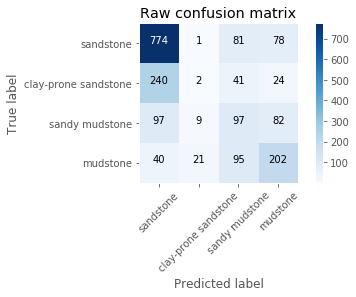

In [26]:
make_confusion_fig(cm, fdset.classes)

In [29]:
df.to_csv('TPM_test.csv', sep='\t', encoding='utf-8')